<a href="https://colab.research.google.com/github/AlexanderCardarasUCSC/EEG-Decoding-to-Images/blob/main/ImageNetGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

View Results Here: https://docs.google.com/presentation/d/1nvqL58J_J7V-mPA3IU3Vue8-aH_fSJ-0lxw7-fBmng0/edit?usp=sharing

**Complete the following steps before running the cells below**

1.
Change runtime to GPU 

>Runtime > Change runtime type > GPU

2.
For each of the following links, add a Google Drive shortcut to your Drive root folder(My Drive):

>https://drive.google.com/drive/folders/1z8wcew5R7GCeu5s7SSsWw8bUcx1urVmk?usp=sharing

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
!pip install opencv-python
!pip install scikit-image
!pip install tensorflow-addons
!mkdir images

     |████████████████████████████████| 679 kB 13.1 MB/s 


# Datasets

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

def append_col_vector(arr):
  temp = np.zeros((len(arr),1))
  new_arr = np.hstack((arr, temp))
  return new_arr

### Flowers

In [2]:
flowers = get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)



# fix resizing issue and save labels
def load_flowers_dataset(scale=True, target_shape=(64, 64), one_hot=False, interp='bilinear', extra_ohe=False):
    print("Loading Flowers dataset")
    print("Target Shape:", target_shape)
    img_gen = ImageDataGenerator() # stored as 0-255
    img_generator = img_gen.flow_from_directory(flowers,
                                                target_size=target_shape,
                                                class_mode='categorical',
                                                shuffle=False,
                                                interpolation=interp)

    data_list = []
    labels = []
    batch_index = 0

    # load images from the generator into data_list and labels
    while batch_index <= img_generator.batch_index:
        data, label = img_generator.next()
        data_list.extend(data)
        labels.extend(label)
        batch_index += 1

    # convert to numpy
    dataset = np.asarray(data_list)
    dataset = dataset.astype('int')
    labels = np.asarray(labels)

    # convert to integer
    if one_hot == False:
        new_labels = []
        for label in labels:
            new_labels.append(np.argmax(label))
        labels = new_labels
        labels = np.asarray(labels)
    else:
        if extra_ohe == True:
            labels = append_col_vector(labels)

    # scaling for tanh
    if scale:
        print("scaling values to the range [-1, 1]")
        dataset = dataset.astype('float32') # caution: storing lots of intermediate representation of image set
        dataset = (dataset - 127.5) / 127.5

    return dataset, labels

### ImageNet

In [3]:
# only exec once to copy image_mapping.npy over to local
!ls /content/gdrive/MyDrive/EEG2Image/data/
!cp /content/gdrive/MyDrive/EEG2Image/data/image_mapping.npy /content/

import numpy as np
import matplotlib.pyplot as plt
import collections
import tensorflow as tf

def array_to_image(img):
    return img.reshape(3, 64, 64).transpose(1, 2, 0) / np.float32(255)


def save_images(image_mapping_array, label_number):
    images = image_mapping_array[label_number]

    # Loop through all images for a specific label and save them
    for index, image in enumerate(images):
        img = array_to_image(image)
        plt.imsave("images/" + str(index) + ".png", img, format="png")


def load_mapping(path, as_dict=False):
    # Load image mapping file
    label2image64 = np.load(path, allow_pickle=True)
    if as_dict:
        return label2image64[()]
    else:
        # Create a numpy ready array of image mappings [[class 0 images], [class 1 images], ... , [class 39 images]]
        return list(collections.OrderedDict(sorted(label2image64[()].items())).values())

def convert_data(data, image_shape=(64,64,3), scale=True):
    print("Converting data shape to 2D with 3 channels")
    if len(image_shape) != 3:
        print("Unexpected image_shape in convert_data")
        return -1
    # change the dimensions and scale
    # create new list to store the data in the correct format
    formatted_data = []
    count = 0
    for image in data:
        count += 1
        # convert from flat to 2D
        # formatted_data.append(array_to_image(image)) # that function changes bounds
        reshaped = image.reshape(3, 64, 64).transpose(1, 2, 0)
        formatted_data.append(reshaped)
    X = np.asarray(formatted_data)
    if scale:
        print("scaling values to the range [-1, 1]")
        X = X.astype('float32') # caution: storing lots of intermediate representation of image set
        X = (X - 127.5) / 127.5
    print("formatted shape:", X.shape)
    return X

def augment_data(images, labels):
    augmented = []
    augmented_labels = []
    for i, image in enumerate(images):
        flipped = tf.image.flip_left_right(image)
        
        augmented.append(image)
        augmented.append(flipped)

        augmented_labels.append(labels[i])
        augmented_labels.append(labels[i])
        
    return np.asarray(augmented), np.asarray(augmented_labels)

# emulate the load_data() function but only return (images, labels)
# scale flag scales the input to [-1, 1] if true
def load_image_net_dataset(scale=True, flip=True, one_hot=False, extra_ohe=False, n_classes=5):
    mapping = load_mapping("image_mapping.npy", as_dict=False)
    # images stored as flat
    images = []
    num_images_per_class = 900
    for elem in mapping:
        images.append(np.asarray(elem[0:num_images_per_class])) # not all the same size so trim to 900 images per class
    images = np.asarray(images)
    num_classes = images.shape[0]
    print("shape of the data:", images.shape) # (40, 900, 12288) but want (900, 64, 64, 3)
    print("classes:", images.shape[0])
    print("images per class:", images.shape[1])
    print("pixel values in images:", images.shape[2])
    
    # append all classes into one list
    mapping = []
    for image_class in range(num_classes):
        for image in range(num_images_per_class):
            # append this image to one long new list
            mapping.append(images[image_class][image])
    mapping = np.asarray(mapping)
    print("shape after removing classes:", mapping.shape)

    data = convert_data(mapping, (64,64,3), scale)[0:900*n_classes]

    # create the labels
    labels = np.arange(0, 40, 1) # create labels 0 -> 39
    labels = np.repeat(labels, num_images_per_class)[0:900*n_classes] # repeat each label for num images per class

    if flip:
        data, labels = augment_data(data, labels)

    # convert to one hot encoded 
    if one_hot == True:
        labels = to_categorical(labels)
        if extra_ohe == True:
            labels = append_col_vector(labels)


    return data, labels

birds_images		 eeg_feature_vectors_2_class.npy  labels_14_70.npy
birds_images.npy	 eeg_norm_linear_55_95.npy	  labels_2_class.npy
birds_labels.npy	 eeg_norm_sigmoid_55_95.npy	  labels_55_95.npy
dataset_features.pickle  image_labels.npy		  labels_5_95.npy
eeg_55_95.npy		 image_mapping.npy
eeg_feature_vectors	 images.npy


In [4]:
data, labels = load_image_net_dataset(one_hot=True, extra_ohe=True)
# data, labels = load_flowers_dataset(one_hot=True, extra_ohe=True)

shape of the data: (40, 900, 12288)
classes: 40
images per class: 900
pixel values in images: 12288
shape after removing classes: (36000, 12288)
Converting data shape to 2D with 3 channels
scaling values to the range [-1, 1]
formatted shape: (36000, 64, 64, 3)


In [7]:
print(data.shape)
print(labels.shape)
print(labels)


(9000, 64, 64, 3)
(9000, 6)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]


# Models

In [8]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
from IPython import display
from tensorflow_addons.layers import SpectralNormalization
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Softmax
import tensorflow as tf
import time

###32x32 Flowers

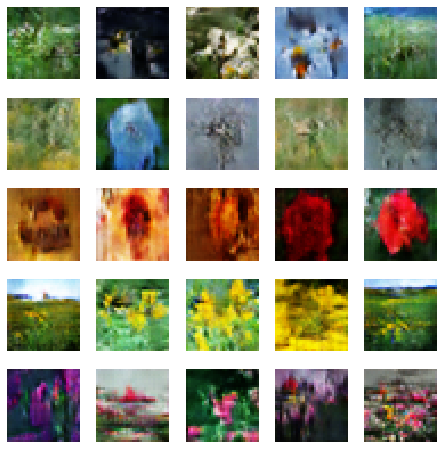

time elapsed:  10.825022220611572
>850, 10/57, d_rf[0.160,0.290], d_class[0.288,0.315] g[2.338,3.581]
>850, 20/57, d_rf[0.188,0.478], d_class[0.358,0.612] g[2.930,4.686]
>850, 30/57, d_rf[0.264,0.147], d_class[0.236,0.136] g[2.606,4.508]
>850, 40/57, d_rf[0.314,0.277], d_class[0.392,0.103] g[2.430,3.708]


In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # label input
    label_input = Input(shape=(n_classes+1,))
    label_embedding = Dense(4*4*256, kernel_initializer=init)(label_input)
    label_embedding = Reshape((4,4,256))(label_embedding) # 4 x 4 x 128
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 4x4 image
    gen = Dense(4*4*256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 256))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, label_embedding])
    
    # upsample to 8x8
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample to 16x16
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample to 32x32
    gen = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    out_layer = Conv2DTranspose(3, (3,3), activation='tanh', padding='same', kernel_initializer=init)(gen)

    # define model
    model = Model([in_lat, label_input], out_layer)
    return model
    

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    fe = Conv2D(64, (4,4), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # downsample to 16x16
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # downsample to 8x8
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # downsample to 4x4
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes+1, activation='softmax')(fe)

    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

### 64x64 ImageNet

In [15]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # label input
    label_input = Input(shape=(n_classes+1,))
    label_embedding = Dense(4*4*256, kernel_initializer=init)(label_input)
    label_embedding = Reshape((4,4,256))(label_embedding) # 4 x 4 x 128
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 4x4 image
    gen = Dense(4*4*256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 256))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, label_embedding])
    
    # upsample to 8x8
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample to 16x16
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample to 32x32
    gen = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 64x64
    gen = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    out_layer = Conv2DTranspose(3, (3,3), activation='tanh', padding='same', kernel_initializer=init)(gen)

    # define model
    model = Model([in_lat, label_input], out_layer)
    return model
    

# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    fe = Conv2D(64, (4,4), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # downsample to 32x32
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)

    # downsample to 16x16
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # downsample to 8x8
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # downsample to 4x4
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes+1, activation='softmax')(fe)

    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

# Healper Function

In [10]:
 # load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = np.random.permutation(images.shape[0])[0:n_samples]
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = to_categorical(randint(0, n_classes, n_samples), n_classes+1)
    fake_labels = to_categorical([(n_classes) for _ in range(n_samples)], n_classes+1)
    return [z_input, labels, fake_labels]

# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples * n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples*n_classes, latent_dim)
    # generate labels
    labels = to_categorical(np.asarray([i for j in range(n_samples) for i in range(n_classes)]), n_classes+1)
    return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input, fake_labels = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input, fake_labels], y
 
# generate samples and save as a plot and save the model
def summarize_performance(epoch, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    images = g_model.predict([seed[0], seed[1]])
    images = ((images + 1)/2.0*255).astype(int)

    # Create subplots
    f, axs = pyplot.subplots(5,5,figsize=(8,8))
#     pyplot.subplots_adjust(hspace=0.25, wspace=-0.89)
    pyplot.subplots_adjust(hspace=0.25, wspace=-0.0)

    # plot images
    for i in range(25):
        axs[i%5,i//5].imshow(images[i], interpolation="none")
        axs[i%5,i//5].axis("off")
        
    display.clear_output(wait=True)
    pyplot.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    pyplot.show()

    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2000, n_batch=32):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    start = time.time()
    # manually enumerate epochs
    for i in range(n_epochs):
        g_rf_temp, g_class_temp, d_rf_1_temp, d_rf_2_temp, d_class_1_temp, d_class_2_temp = [],[],[],[],[],[]
        # enumerate batches over the training set
        end = time.time()
        print("time elapsed: ", end - start)
        start = time.time()
        for j in range(bat_per_epo):
            for k in range(1):
                # get randomly selected 'real' samples
                [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
                
                # update discriminator model weights
                _d_loss_1, _d_rf_1, _d_class_1 = d_model.train_on_batch(X_real, [y_real, labels_real])

                # generate 'fake' examples
                [X_fake, labels, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                # update discriminator model weights
                _d_loss_2, _d_rf_2, _d_class_2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input, fake_labels] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            _g_loss, _g_rf, _g_class = gan_model.train_on_batch([z_input, labels_input], [y_gan, labels_input])
            
            # summarize loss on this batch
            if (j+1) % 10 == 0:
                d_rf_1_temp.append(_d_rf_1)
                g_rf_temp.append(_g_rf)
                d_class_1_temp.append(_d_class_1)
                g_class_temp.append(_g_class)
            
                print('>%d, %d/%d, d_rf[%.3f,%.3f], d_class[%.3f,%.3f] g[%.3f,%.3f]' %
                    (i+1, j+1, bat_per_epo, _d_rf_1, _d_rf_2, _d_class_1, _d_class_2, _g_rf, _g_class))

        if i % 2 == 0:
            summarize_performance(i, g_model, latent_dim)
            d_loss1.append(sum(d_rf_1_temp) / len(d_rf_1_temp))            
            d_loss2.append(sum(d_class_1_temp) / len(d_class_1_temp))            
            g_loss1.append(sum(g_rf_temp) / len(g_rf_temp))
            g_loss2.append(sum(g_class_temp) / len(g_class_temp))
        if (i+1) % 150 == 0: 
            # evaluate the model performance, sometimes
            test_image_count = 1000
            [samples_fake, _, _], _ = generate_fake_samples(g_model, latent_dim, test_image_count)
            samples_fake = ((samples_fake + 1)/2.0*255).astype('float32')

            [samples_real, _], _ = generate_real_samples(dataset, test_image_count)
            samples_real = ((samples_real + 1)/2.0*255).astype('float32')
            
            _is = get_inception_score([sample for sample in samples_fake], splits=10)[0]
            IS.append(_is) 

            _fid = calculate_fid(samples_real, samples_fake)
            FID.append(_fid)
            
            print("IS:",_is,",FID:",_fid)
            

     

#Run

In [11]:
N_CLASSES = 5

# Flowers Dataset
# dataset = load_flowers_dataset(target_shape=(32,32), one_hot=True, extra_ohe=True)

# ImageNet Dataset
dataset = load_image_net_dataset(one_hot=True, extra_ohe=True, n_classes=N_CLASSES)

shape of the data: (40, 900, 12288)
classes: 40
images per class: 900
pixel values in images: 12288
shape after removing classes: (36000, 12288)
Converting data shape to 2D with 3 channels
scaling values to the range [-1, 1]
formatted shape: (36000, 64, 64, 3)


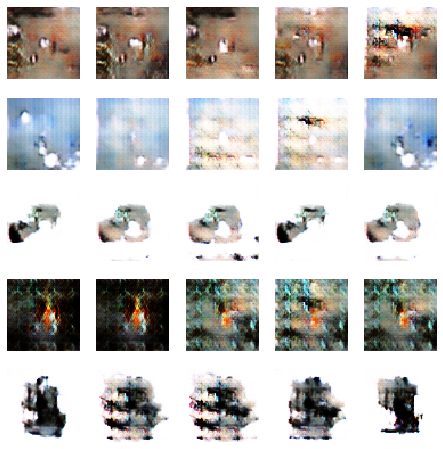

time elapsed:  41.65926456451416
>44, 10/140, d_rf[0.096,0.150], d_class[0.538,0.107] g[3.228,3.895]
>44, 20/140, d_rf[0.263,0.106], d_class[0.688,0.054] g[3.295,4.118]
>44, 30/140, d_rf[0.438,0.253], d_class[0.836,0.283] g[3.400,4.258]
>44, 40/140, d_rf[0.178,0.088], d_class[0.374,0.109] g[3.535,4.497]
>44, 50/140, d_rf[0.218,0.163], d_class[0.559,0.124] g[3.374,4.334]
>44, 60/140, d_rf[0.119,0.374], d_class[0.611,0.371] g[3.653,4.288]
>44, 70/140, d_rf[0.358,0.203], d_class[0.881,0.166] g[2.949,3.741]
>44, 80/140, d_rf[0.239,0.143], d_class[0.922,0.095] g[3.287,4.310]


KeyboardInterrupt: ignored

In [16]:
       
g_loss1, g_loss2, d_loss1, d_loss2, IS, FID = [],[],[],[],[],[]
# size of the latent space
latent_dim = 100
n_epochs = 1501
batch_size = 64
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

# create a seeded latent space for visualization
seed = generate_seeded_points(latent_dim, 5)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size)

# Visualization

100


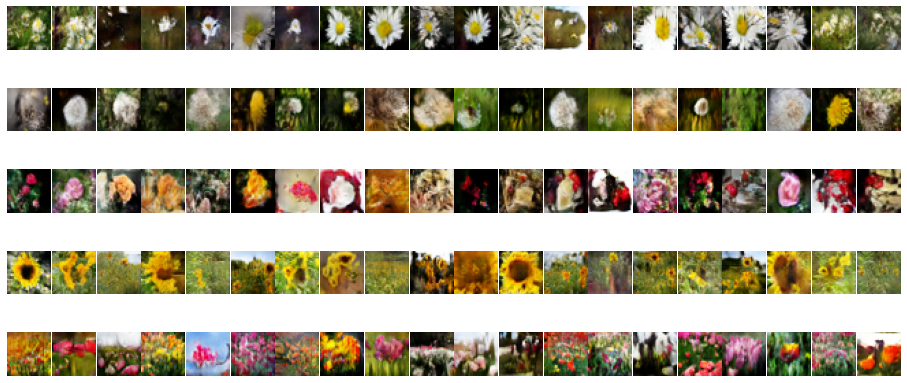

In [ ]:
# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples_per_class, n_classes):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples_per_class * n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples_per_class * n_classes, latent_dim)
    # generate labels
    labels = to_categorical(np.asarray([j for j in range(n_classes) for i in range(n_samples_per_class)]),n_classes+1)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(gen, latent_dim, n_samples_per_class, n_classes):
    # generate points in latent space
    z_input, labels_input = generate_seeded_points(latent_dim, n_samples_per_class, n_classes)
    # predict outputs
    images = gen.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples_per_class, 1))
    return [images, labels_input], y


n_samples_per_class = 20
n_classes = 5
# Notice `training` is set to False.
# This is so all layers run in inference mode (batchnorm).
predictions = generate_fake_samples(g_model, 100, n_samples_per_class, n_classes)[0][0]
predictions = ((predictions + 1)/2.0*255).astype(int)

print(len(predictions))
# plot the result
f, axs = pyplot.subplots(n_classes, n_samples_per_class, figsize=(16,16))
pyplot.subplots_adjust(hspace=-0.85, wspace=0.03)
# plot images
for i in range(n_classes):
    for j in range(n_samples_per_class):
#         print(i*n_classes + j)
        axs[i,j].imshow(predictions[(i*n_samples_per_class) + j])
        axs[i,j].axis("off")


pyplot.savefig("sample_current_epoch.png")
pyplot.show()

In [ ]:
import imageio
import glob

anim_file = 'Jason_gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        print(filename)
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
import cv2
step = 100
n_rows = 3
n_cols = 5
pic = None
row = None

for j in range(n_rows):
    for i in range(0,n_cols):
        image_name = "images/image_at_epoch_%.4d"%((i*step) + (j*step*n_cols))+".png"
        print(image_name)

    #     img = cv2.imread(image_name)[64:-64,450:-350]
        img = cv2.imread(image_name)[64:-64,30:-60]

        if row is None:
            row = img
        else:
            row = np.hstack((row,img))
            
    if pic is None:
        pic = row
    else:
        print(pic.shape)
        
        pic = np.vstack((pic, 255*np.ones((80, pic.shape[1],3))))
        pic = np.vstack((pic, row))
    row = None
    


cv2.imwrite("seeded_evolution.png",pic)

images/image_at_epoch_0000.png
images/image_at_epoch_0100.png
images/image_at_epoch_0200.png
images/image_at_epoch_0300.png
images/image_at_epoch_0400.png
images/image_at_epoch_0500.png
images/image_at_epoch_0600.png
images/image_at_epoch_0700.png
images/image_at_epoch_0800.png
images/image_at_epoch_0900.png
(448, 2430, 3)
images/image_at_epoch_1000.png
images/image_at_epoch_1100.png
images/image_at_epoch_1200.png
images/image_at_epoch_1300.png
images/image_at_epoch_1400.png
(976, 2430, 3)


True

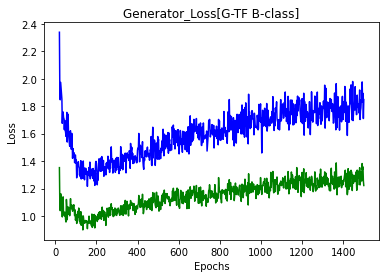

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.title("Generator_Loss[G-TF B-class]")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot([i*2 for i in range(10,len(g_loss1))], np.array(g_loss1)[10:], color="green")
plt.plot([i*2 for i in range(10,len(g_loss2))], np.array(g_loss2)[10:], color="blue")
plt.show()
plt.savefig("Generator_Loss[G-TF_B-class.png")

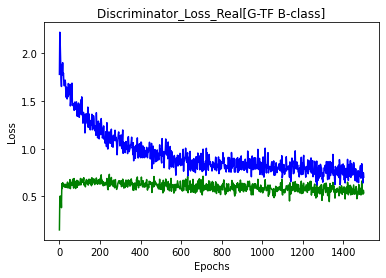

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title("Discriminator_Loss_Real[G-TF B-class]")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot([i*2 for i in range(0,len(d_loss1))], np.array(d_loss1)[0:], color="green")
plt.plot([i*2 for i in range(0,len(d_loss2))], np.array(d_loss2)[0:], color="blue")
plt.show()
plt.savefig("Discriminator_Loss_Real[G-TF_B-class].png")

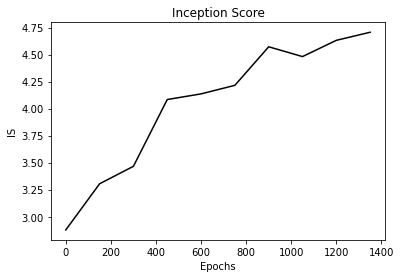

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title("Inception Score")
plt.xlabel("Epochs")
plt.ylabel("IS")
plt.plot([i*150 for i in range(len(IS))], np.array(IS), color="black")
plt.show()
plt.savefig("Inception_Score.png")

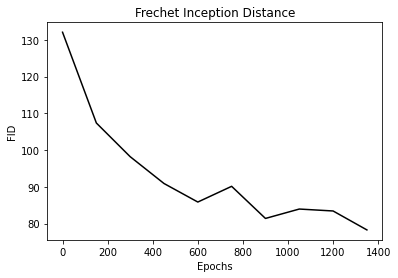

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title("Frechet Inception Distance")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.plot([i*150 for i in range(len(FID))], np.array(FID), color="black")
plt.show()
plt.savefig("Frechet_Inception_Distance.png")

In [ ]:
# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples_per_class, n_classes):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples_per_class * n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples_per_class * n_classes, latent_dim)
    # generate labels
    labels = to_categorical(np.asarray([j for j in range(n_classes) for i in range(n_samples_per_class)]),n_classes+1)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(gen, latent_dim, n_samples_per_class, n_classes):
    # generate points in latent space
    z_input, labels_input = generate_seeded_points(latent_dim, n_samples_per_class, n_classes)
    # predict outputs
    images = gen.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples_per_class, 1))
    return [images, labels_input], y


n_samples_per_class = 10
n_classes = 5

# This is so all layers run in inference mode (batchnorm).
predictions = generate_fake_samples(g_model, 100, n_samples_per_class, n_classes)[0][0]
predictions = ((predictions + 1)/2.0*255)
 
nearest_predictions = []
for i, prediction in enumerate(predictions):
    print("Finding nearest neighbor...", i,"/",(n_samples_per_class*n_classes))
    
    upscaled_prediction = resize(prediction, (224,224,3), 3)
    images, distances = find_nearest_neighbors(upscaled_prediction, 1)
    
    nearest_predictions.append(upscaled_prediction)
    nearest_predictions.append(images[0])

# plot the result
f, axs = pyplot.subplots(n_classes, n_samples_per_class*2, figsize=(16,16))
pyplot.subplots_adjust(hspace=-0.85, wspace=0.03)
# plot images
for i in range(n_classes):
    for j in range(n_samples_per_class*2):
        # Generated Imges
        axs[i,j].imshow(nearest_predictions[(i*n_samples_per_class*2) + j].astype(int))
        axs[i,j].axis("off")


pyplot.savefig("nearest.png")
pyplot.show()

Finding nearest neighbor... 0 / 50


NameError: name 'find_nearest_neighbors' is not defined

#Analysis

### Inception Score

In [ ]:
import os
import numpy as np
from PIL import Image
import math
from random import randint
from PIL import Image
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import os.path
import tarfile
import numpy as np
from six.moves import urllib
import tensorflow as tf
import math
import sys


MODEL_DIR = '/tmp/imagenet'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None


# Call this function with list of images. Each of elements should be a
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
  assert(type(images) == list)
  assert(type(images[0]) == np.ndarray)
  assert(len(images[0].shape) == 3)
  assert(np.max(images[0]) > 10)
  assert(np.min(images[0]) >= 0.0)
  inps = []
  for img in images:
    img = img.astype(np.float32)
    inps.append(np.expand_dims(img, 0))
  bs = 1
  with tf.compat.v1.Session() as sess:
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        sys.stdout.write(".")
        sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {'ExpandDims:0': inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)


# This function is called automatically.
def _init_inception():
  global softmax
  if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(MODEL_DIR, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
  with tf.compat.v1.gfile.FastGFile(os.path.join(
      MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
  # Works with an arbitrary minibatch size.
  with tf.compat.v1.Session() as sess:
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            shape = [s for s in shape]
            new_shape = []
            for j, s in enumerate(shape):
                if s == 1 and j == 0:
                    new_shape.append(None)
                else:
                    new_shape.append(s)
            o.set_shape(tf.TensorShape(new_shape))
    w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
    logits = tf.matmul(tf.squeeze(pool3, [1, 2]), w)
    softmax = tf.nn.softmax(logits)


if softmax is None:
  _init_inception()

Instructions for updating:
Use tf.gfile.GFile.


### FID
**https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/**

In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
from tensorflow.keras.datasets.mnist import load_data
from skimage.transform import resize

# prepare the inception v3 model
fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)
 
# calculate frechet inception distance
def _calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_fid(real_images, fake_images):
    r = real_images.astype("float32")
    r = scale_images(r, (299,299,3))
    r = preprocess_input_inception_v3(r)

    f = fake_images.astype("float32")
    f = scale_images(f, (299,299,3))
    f = preprocess_input_inception_v3(f)
    
    fid = _calculate_fid(fid_model, r, f)
    return fid

### Nearest Image Search
**https://www.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html**

In [ ]:
import numpy as np
from numpy.linalg import norm
import pickle
# from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from sklearn.neighbors import NearestNeighbors

# print("Loading ResNet50 model")
_nearest_feature_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Loading Images")
_nearest_image_list, _ = load_flowers_data(target_shape=(224, 224), one_hot=True, extra_ohe=True, scale=False)
print("Loading Features")
_nearest_feature_list = pickle.load(open('dataset_features.pickle', 'rb'))
print("Calculating Nearest Neighbors")
_neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(_nearest_feature_list)
print("Done")


# scale an array of images to a new size
def scale_image(image, new_shape):
    return resize(image, (224,224,3), 3)

def extract_features(img_array, model):
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input_resnet50(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

def find_nearest_neighbors(image, n_neighbors=1): 
    image = scale_image(image, (224,224,3))
    image_feature = extract_features(image, _nearest_feature_model)
    distances, indices = _neighbors.kneighbors([image_feature])
    return _nearest_image_list[indices[0][0:n_neighbors]], distances[0][0:n_neighbors]



94773248/94765736 [==============================] - 1s 0us/step
Loading Images
Loading Flowers dataset
Target Shape: (224, 224)
Found 3670 images belonging to 5 classes.
Loading Features


FileNotFoundError: [Errno 2] No such file or directory: 'dataset_features.pickle'